In [16]:
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

from scipy import stats

%matplotlib inline

np.random.seed(12345678)  #fix random seed to get the same result

Lets test the statistical compatability of the x-distributions of our histograms. In order to do this, we first need to import the file.

In [17]:
f = r.TFile("./data/gm2offline_ana_merged.root")
f.cd()
f.ls()

def GetKeyNames( self, dir = "" ):
        self.cd(dir)
        return [key.GetName() for key in r.gDirectory.GetListOfKeys()]
r.TFile.GetKeyNames = GetKeyNames

keyList = f.GetKeyNames("")
print ("\nKeys in file:", keyList)
#h = r.TH3D()
#f.GetObject(keyList[1], h)


Keys in file: ['clusters']
TFile**		./data/gm2offline_ana_merged.root	chain files
 TFile*		./data/gm2offline_ana_merged.root	chain files
  KEY: TTree	clusters;1	clusters


In [18]:
clusters = r.TTree()
f.GetObject('clusters',clusters)
n2 = clusters.Draw("x:y","energy>1660 && energy<6000 && time*1.25 > 30000 && time*1.25 < 650000 && caloNum==2","goff")

In [19]:
print(clusters.GetV1(),clusters.GetEntries())

<Double_t buffer, size 2147483647> 101741458


In [20]:
vecx2 = []
vecy2 = []
for i in range(n2):
    if(i % 100 == 0):
        vecx2.append(clusters.GetV1()[i])
        vecy2.append(clusters.GetV2()[i])

In [21]:
print(len(vecx2),len(vecy2))

3717 3717


In [22]:
n8 = clusters.Draw("x:y","energy>1660 && energy<6000 && time*1.25 > 30000 && time*1.25 < 650000 && caloNum==8","goff")
vecx8 = []
vecy8 = []
for i in range(n8):
    if(i % 100 == 0):
        vecx8.append(clusters.GetV1()[i])
        vecy8.append(clusters.GetV2()[i])
    
print(n8)

474066


In [23]:
print(n8, len(vecx8), len(vecy8))

474066 4741 4741


In [24]:
# https://github.com/syrte/ndtest/blob/master/ndtest.py

In [25]:
from __future__ import division
import numpy as np
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import kstwobign, pearsonr
from scipy.stats import genextreme

__all__ = ['ks2d2s', 'estat', 'estat2d']


def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    '''
    Two-dimensional Kolmogorov-Smirnov test on two samples. 
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.

    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic. Returned if keyword `extra` is True.

    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate, but it certainly implies that the two samples are not significantly different. (cf. Press 2007)

    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, Monthly Notices of the Royal Astronomical Society, vol. 202, pp. 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, Monthly Notices of the Royal Astronomical Society, vol. 225, pp. 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''

    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = random.choice(n, n1, replace=True)
            #ix2 = random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p


def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d


def estat2d(x1, y1, x2, y2, **kwds):
    return estat(np.c_[x1, y1], np.c_[x2, y2], **kwds)


def estat(x, y, nboot=1000, replace=False, method='log', fitting=False):
    '''
    Energy distance statistics test.
    Reference
    ---------
    Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
      multivariate goodness-of-fit tests, two-sample comparison and unfolding.
      Nuc Instr and Meth in Phys Res A 537: 626-636
    Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
      based on distances. J Stat Planning & Infer 143: 1249-1272
    Brian Lau, multdist, https://github.com/brian-lau/multdist

    '''
    n, N = len(x), len(x) + len(y)
    stack = np.vstack([x, y])
    stack = (stack - stack.mean(0)) / stack.std(0)
    if replace:
        rand = lambda x: random.randint(x, size=x)
    else:
        rand = random.permutation

    en = energy(stack[:n], stack[n:], method)
    en_boot = np.zeros(nboot, 'f')
    for i in range(nboot):
        idx = rand(N)
        en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

    if fitting:
        param = genextreme.fit(en_boot)
        p = genextreme.sf(en, *param)
        return p, en, param
    else:
        p = (en_boot >= en).sum() / nboot
        return p, en, en_boot


def energy(x, y, method='log'):
    dx, dy, dxy = pdist(x), pdist(y), cdist(x, y)
    n, m = len(x), len(y)
    if method == 'log':
        dx, dy, dxy = np.log(dx), np.log(dy), np.log(dxy)
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
    z = dxy.sum() / (n * m) - dx.sum() / n**2 - dy.sum() / m**2
    # z = ((n*m)/(n+m)) * z # ref. SR
    return z

In [26]:
x1 = np.array([1,1,1,1])
x2 = np.array([1,1,1,1])
y1 = np.array([1,1,1,1])
y2 = np.array([1,1,1,1])

print(x1)
print(ks2d2s(x1,y1,x2,y2,100,True))

[1 1 1 1]
(0.0, 0.25)


In [27]:
import time

start = time.time()
print("Beginning KS Test")
print(ks2d2s(np.array(vecx2),np.array(vecy2),np.array(vecx8),np.array(vecy8),None,False))
end = time.time()
print(end - start)

Beginning KS Test
9.979471560290219e-22
0.8067080974578857


In [28]:
import time

start = time.time()
print("Beginning KS Test")
print(ks2d2s(np.array(vecx2),np.array(vecy2),np.array(vecx2),np.array(vecy2),2,False))
end = time.time()
print(end - start,"seconds")

Beginning KS Test
1.0
1.9161427021026611 seconds


In [29]:
FullResult_8_2 = (0.0, 0.11412472777137199)

In [30]:
start = time.time()
print("Beginning KS Test")
print(ks2d2s(np.array(vecx2),np.array(vecy2),np.array(vecx2),np.array(vecy2),None,False))
end = time.time()
print(end - start, "seconds")

Beginning KS Test
1.0000000000000018
0.6488778591156006 seconds


In [31]:
vecxVec = []
vecyVec = []

for j in range(24):
    print("Starting Calo",j+1)
    nj = clusters.Draw("x:y","energy>1660 && energy<6000 && time*1.25 > 30000 && time*1.25 < 650000 && caloNum=="+str(j+1)
                       ,"goff")
    vecxj = []
    vecyj = []
    for i in range(nj):
        if(i % 100 == 0):
            vecxj.append(clusters.GetV1()[i])
            vecyj.append(clusters.GetV2()[i])
    vecxVec.append( vecxj )
    vecyVec.append( vecyj )

Starting Calo 1
Starting Calo 2
Starting Calo 3
Starting Calo 4
Starting Calo 5
Starting Calo 6
Starting Calo 7
Starting Calo 8
Starting Calo 9
Starting Calo 10
Starting Calo 11
Starting Calo 12
Starting Calo 13
Starting Calo 14
Starting Calo 15
Starting Calo 16
Starting Calo 17
Starting Calo 18
Starting Calo 19
Starting Calo 20
Starting Calo 21
Starting Calo 22
Starting Calo 23
Starting Calo 24
Starting Calo 25
474066


Warning in <TTreePlayer::DrawSelect>: The selected TTree subset is empty.


In [39]:
ksResultsVec = []

for i in range(24):
    for j in range(24):
        if i >= j:
            print(i+1,j+1)
#            print(ks2d2s(np.array(vecxVec[i]),np.array(vecyVec[i]),np.array(vecxVec[j]),np.array(vecyVec[j]),None,False))
            ksResultsVec.append((i+1,j+1, ks2d2s(np.array(vecxVec[i]),np.array(vecyVec[i]),
                                                np.array(vecxVec[j]),np.array(vecyVec[j]),
                                                None,False)))
    
print(ksResultsVec)

1 1
2 1
2 2
3 1
3 2
3 3
4 1
4 2
4 3
4 4
5 1
5 2
5 3
5 4
5 5
6 1
6 2
6 3
6 4
6 5
6 6
7 1
7 2
7 3
7 4
7 5
7 6
7 7
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
15 13
15 14
15 15
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 14
18 15
18 16
18 17
18 18
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 11
19 12
19 13
19 14
19 15
19 16
19 17
19 18
19 19
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8


NameError: name 'ksReusltsVec' is not defined

Warning in <TFile::Append>: Replacing existing TH1: 2D Kolmogorov-Smirnov Comparison of Calorimeters (Potential memory leak).


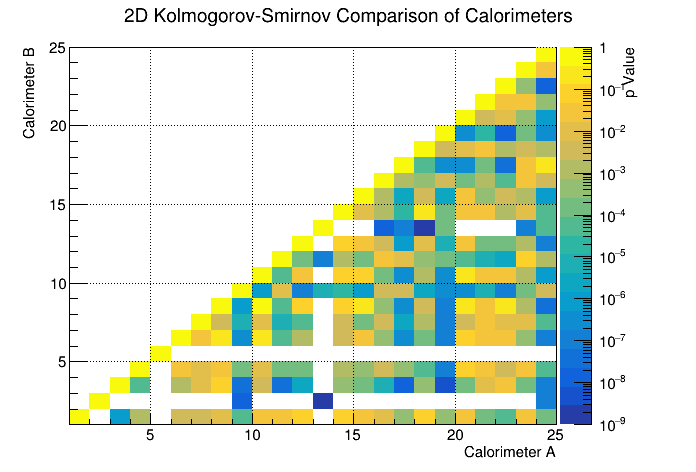

In [49]:
#print(ksResultsVec)
#hist2d.Delete()
hist2d = r.TH2D('2D Kolmogorov-Smirnov Comparison of Calorimeters','hist2d',24,1,25,24,1,25)
for calo1, calo2, p in ksResultsVec:
    hist2d.Fill(calo1,calo2,p)
#    if p>0:
#        print(calo1,calo2,p)
hist2d.SetTitle("2D Kolmogorov-Smirnov Comparison of Calorimeters")
hist2d.GetXaxis().SetTitle("Calorimeter A")
hist2d.GetYaxis().SetTitle("Calorimeter B")
hist2d.GetZaxis().SetTitle("p Value")
c = r.TCanvas()
hist2d.Draw("COLZ")
c.SetLogz()
hist2d.GetZaxis().SetRangeUser(0.000000001,1)
c.SetGridx()
c.SetGridy()
c.SetRightMargin(0.2)
c.Draw()

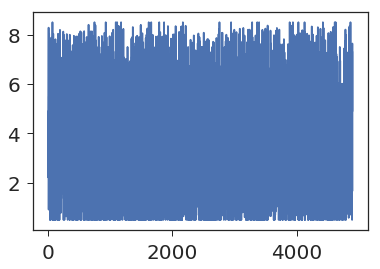

In [84]:
plt.plot(vecxVec[10-1])

In [98]:
ksShiftVec = []
for j in range(17*5):
    testx = vecxVec[10-1].copy()
    testy = vecyVec[10-1].copy()
    badIndex = []
    for i, x in enumerate(testx):
        if x < 0.1*j:
            badIndex.append(i)
    for i in sorted(badIndex, reverse=True):
        del(testx[i])
        del(testy[i])
    ksShiftVec.append((0.1*j,ks2d2s(np.array(vecxVec[2-1]),np.array(vecyVec[2-1]),
                                                np.array(testx),np.array(testy),
                                                None,False)))
#    plt.plot(testx,testy)
#    plt.show()
    

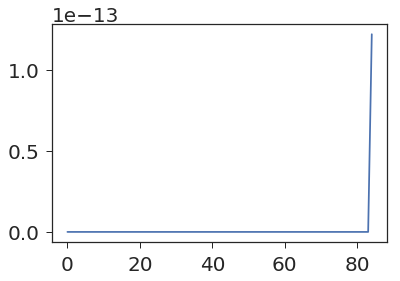

In [99]:
i, ks = zip(*ksShiftVec)
plt.plot(ks)

In [69]:
badIndex = []
for i, x in enumerate(testx):
    if x < 5.75:
#        print(i,x)
        badIndex.append(i)
        
print(badIndex)

0 0.7894691857497241
2 1.5
3 5.499999999999999
4 4.955970054978041
5 3.7317707705134175
6 2.739677837903182
7 2.5
8 2.5000000000000004
9 2.7104911729607437
11 5.724421701760619
12 2.725038199951615
13 1.3161336623534532
16 1.182400623520864
18 4.9723332340540916
19 1.5
20 3.5
22 1.2736449007204471
23 1.7778187284730915
25 2.7996251696917294
26 1.0996832439984265
27 3.0652404350389557
28 2.924260583840017
29 1.6133756367501215
30 2.7215164325094148
31 2.5
32 1.5000000000000002
33 4.5
34 2.984789886994863
35 3.0063963283259287
37 4.5
38 3.5
39 2.72615185644615
40 5.5
41 1.5
42 1.6900758283272947
43 1.3937938776263243
44 5.06537791749586
45 3.841436329735633
46 2.5
47 3.5000000000000004
48 4.042687002295942
49 0.8815823359395311
50 2.5
51 2.5
53 2.935702166550907
54 4.058355547808586
55 4.8987161161058435
57 1.8426001852526719
59 2.5
60 2.5000000000000004
61 5.743483315050525
62 1.5
63 1.5
64 1.5
65 4.7915211819659875
66 0.985171438894744
67 1.5887220280218963
68 1.4999999999999998
69 3.5

In [70]:
for i in sorted(badIndex, reverse=True):
    del(testx[i])
    del(testy[i])

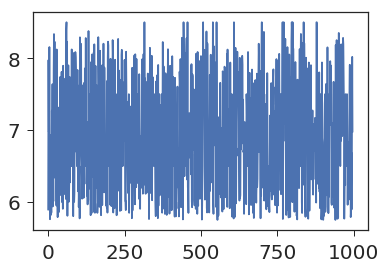

In [71]:
plt.plot(testx)